## codes for data processing for input data
- input : dictionary의 형태에 해당(즉 벡터형태)
- 단, 예외적으로 긍/부정에 상관없이 나오는 단어들(즉 모든 dataset에 uniform하게 나오는 단어들)은 제거
- 모든 document에 극소하게 나오는 단어도 제외 
- **dictionary를 reference로 사용하여 주어진 document에 해당 단어가 몇 번이나 나오는지(frequency)를 가지고 하나의 벡터를 생성한다 = input 형태**

In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
review_data = load_files(r"/content/gdrive/My Drive/Colab Notebooks/movie_review",categories=['pos','neg'])

In [5]:
X,y = review_data.data, review_data.target # 해당 feature이 될 데이터와 neg,pos값

In [6]:
#X # 문장형태로 된 feature

In [7]:
y[:10] # 1,0형태 

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [8]:
documents = []

In [9]:
stemmer = WordNetLemmatizer() # 표제어 추출하는 객체 

In [10]:
for sen in range(0, len(X)):
  # 긍, 부정에 영향을 주지 않는 단어 삭제 
  # remove all the special character
  document = re.sub(r'\W',' ', str(X[sen]))
  # remove all single characters
  document = re.sub(r's+[a-zA-Z]\s+',' ',document);
  # remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
  # substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)
  # removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)
  # converting to LowerCase
  document = document.lower()

  # Lemmatization(표제어 추출)
  document = document.split()
  document = [stemmer.lemmatize(word) for word in document]
  document = ' '.join(document)

  documents.append(document) # 필요없는 형태 제거와 표제어 추출 결과를 리스트에 저장

In [244]:
# CountVectorizer : 단어 토큰 생성, 각 단어의 수를 세어 BOW 인코딩한 벡터 생성 
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

In [245]:
X = vectorizer.fit_transform(documents).toarray()

In [246]:
X.shape # 1000개의 문서에서  단어 딕셔너리 reference생성 

(2000, 1500)

In [247]:
# TfidfTransformer : CountVectorizer와 비슷하나, TF-IDF 방식으로 단어의 가중치 조정 
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [249]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [250]:
#y_train = y_train.reshape(y_train.shape[0],1)
#y_test = y_test.reshape(y_test.shape[0],1)

In [251]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1400, 1500) (600, 1500) (1400,) (600,)


## training(Optimization)

In [252]:
# h, sigmoid함수 정의 
# activation function으로 sigmoid를 사용할 예정에 있음 
def h(theta,X):
  return np.dot(X,theta)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 미분한 sigmoid식
def Dsigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

In [253]:
# 순전파 함수
# 여기서의 theta는 각 layer별로 해당하는 theta를 전부 포함한 list에 해당한다. 
def Forward(image, theta_vector):
    z_each_layer = []

    # theta의 수대로 반복하고, 그에따라 각각 저장해야 한다. 
    for i in range(len(theta_vector)):
      image = add_bias(image)
      theta = theta_vector[i]
      z = np.dot(image, theta)
      a = sigmoid(z)
      z_each_layer.append(a) # z와 a값 모두 저장한다
      image = a

    return z_each_layer

In [254]:
# label의 원핫인코딩을 위한 함수 
def onehotencoding(label):
  unique = np.unique(label)
  m = label.shape[0]
  n = unique.shape[0]
  empty = np.zeros((m, n))

  for i in range(m):
    for j in range(n):
      if label[i] == unique[j]:
        empty[i, j] = 1
  
  return empty

In [255]:
# Objective function에 대한 정의 
# regularization term추가 (L의 값은 lambda에 해당한다)
def ObjectiveFunction(image, theta_vector,label_list,L ):
  h = Forward(image, theta_vector) # 순전파로 계산한 값의 h(각 layer별로 a값을 출력한다. )
  sigmoid_value = [h[0], h[1], h[2]]
  output_layer = sigmoid_value[-1] # 마지막 h[2]가 결국은 output layer에 해당한다. 
  n = len(theta_vector)# theta의 수에 해당한다, 
  # m = image.shape[0] # 이부분 식 수정해야 하는지 확인하기 

  # cost function에 대해 regularization term을 추가한다. 
  reg_value = 0
  for theta in range(len(theta_vector)): 
    reg_value += np.sum(theta*theta)
  reg_value *= float(L)/(2*n) # m으로 바꿔야 하는지 확인하기 
   
  cost = -np.mean(np.sum(label_list*np.log(output_layer) + (1 - label_list)*np.log(1 - output_layer), axis=1)) #해당 J(theta)값
  
  return cost+reg_value, sigmoid_value

In [256]:
#def predict(output_layer):
#  predict_label = np.where(output_layer > 0.5, 1 , 0)
#  return predict_label

In [257]:
def predict(output_layer):
  predict_label = np.argmax(output_layer, axis=1)
  return predict_label

In [258]:
# accuracy
def accuracy(pred, true):
  acc = np.mean(pred == true)
  return acc

In [259]:
# bias 추가 
def add_bias(image):
  m = image.shape[0]
  temp = np.column_stack((np.ones((m, 1)), image))
  return temp

In [260]:
# 역전파 함수 수정 
def Back(image, theta_list, onehot, sigmoid_list):
  m = image.shape[0]
  delta4 = sigmoid_list[2] - onehot
  delta3 = np.dot(delta4, theta_list[2][1:, :].T)*sigmoid_list[1]*(1-sigmoid_list[1])
  delta2 = np.dot(delta3, theta_list[1][1:, :].T)*sigmoid_list[0]*(1-sigmoid_list[0])

  add_bias_term3 = add_bias(sigmoid_list[1])
  add_bias_term2 = add_bias(sigmoid_list[0])
  add_bias_term1 = add_bias(image)
  
  gradient3 = np.dot(add_bias_term3.T, delta4) / m
  gradient2 = np.dot(add_bias_term2.T, delta3) / m
  gradient1 = np.dot(add_bias_term1.T, delta2) / m
  gradient_list = [gradient1, gradient2, gradient3]

  return gradient_list

In [261]:
y_train.shape

(1400,)

In [262]:
y_train_one = onehotencoding(y_train)
y_test_one = onehotencoding(y_test)

In [263]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [264]:
y_train_one

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [268]:
# 먼저 theta의 행렬의 형태에 대한 정의가 필요하다.  
# 랜덤으로 정한 theta (U,V,W)에 해당 
np.random.seed(20180378)

# 파라미터 수를 늘리므로 더작은 std의 N(0,1)에서 랜덤값 뽑을 것임 initializer수정
theta1 = np.random.randn(1501, 99) 
theta2 = np.random.randn(100, 99)
theta3 = np.random.randn(100, 2)



# 정한 theta들의 리스트
theta_vector = [theta1, theta2, theta3]
train_cost_value_list = []
test_cost_value_list = []
train_accuracy_list = []
test_accuracy_list = []

In [269]:
# hyperparameter값 (튜닝예정 )
iteration = 5000
learning_rate = 0.35
L = 2000 # reg term의 lambda값

In [270]:
for iter in range(iteration):

  # compute cost
  train_cost_value, train_sigmoid_value = ObjectiveFunction(X_train, theta_vector, y_train_one, L)
  test_cost_value, test_sigmoid_value = ObjectiveFunction(X_test, theta_vector, y_test_one, L)
  # predict the final label 
  train_predict_label = predict(train_sigmoid_value[-1])
  test_predict_label = predict(test_sigmoid_value[-1])
 
  # compute accuracy
  train_accuracy = accuracy(train_predict_label, y_train)
  test_accuracy = accuracy(test_predict_label, y_test)
  gradient = Back(X_train, theta_vector, y_train_one, train_sigmoid_value)

  # append
  train_cost_value_list.append(train_cost_value)
  test_cost_value_list.append(test_cost_value)
  train_accuracy_list.append(train_accuracy)
  test_accuracy_list.append(test_accuracy)
  if iter > 300 :
    learning_rate = 0.2
  elif iter > 800 :
    learning_rate = 0.1
  # theta update 
  for i in range(len(theta_vector)):
    theta_vector[i] = theta_vector[i] - learning_rate * gradient[i]
  
  # update되는 cost, sccuracy값 확인하기 
  if(iter%50 == 0):
    print("train:",train_cost_value, train_accuracy )
    print("test :", test_cost_value, test_accuracy) 

train: 1668.5399369150189 0.5257142857142857
test : 1668.5384875644697 0.495
train: 1669.2535971225407 0.5014285714285714
test : 1669.3311524928074 0.49666666666666665
train: 1668.7941402942213 0.5014285714285714
test : 1668.8659687425202 0.49666666666666665
train: 1668.561765149782 0.5021428571428571
test : 1668.6415708082736 0.49666666666666665
train: 1668.473067912902 0.5028571428571429
test : 1668.5663562940535 0.49666666666666665
train: 1668.4039455270195 0.5035714285714286
test : 1668.5126662408138 0.49833333333333335
train: 1668.3485198785766 0.5042857142857143
test : 1668.47325153834 0.5016666666666667
train: 1667.8746243852097 0.6971428571428572
test : 1668.0424131593043 0.5883333333333334
train: 1667.848163099845 0.7057142857142857
test : 1668.0370688093494 0.5966666666666667
train: 1667.823904002794 0.71
test : 1668.0312356376435 0.595
train: 1667.8003264074239 0.7192857142857143
test : 1668.0255465133987 0.6083333333333333
train: 1667.7768623488687 0.7278571428571429
test :

## plot the loss curve

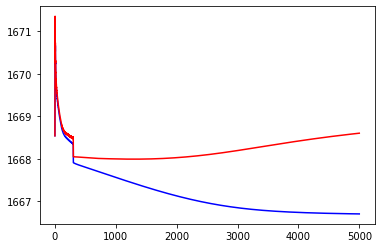

In [271]:
import matplotlib.pyplot as plt

plt.plot(train_cost_value_list,'b') # train
plt.plot(test_cost_value_list,'r') # test

## plot the accuracy curve

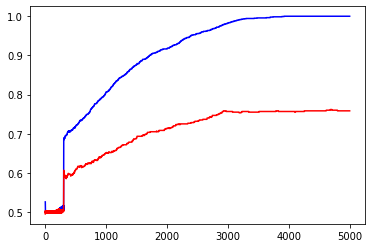

In [272]:
plt.plot(train_accuracy_list,'b')
plt.plot(test_accuracy_list,'r')

## plot the quantitative results

In [273]:
# training results
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# confusion matrix 
print(confusion_matrix(y_train,train_predict_label))
# classification results
print(classification_report(y_train,train_predict_label))
# accuracy_score
print(accuracy_score(y_train, train_predict_label))

[[698   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

1.0


In [274]:
# testing results
print(confusion_matrix(y_test,test_predict_label))
print(classification_report(y_test,test_predict_label))
print(accuracy_score(y_test, test_predict_label))

[[230  72]
 [ 73 225]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       302
           1       0.76      0.76      0.76       298

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

0.7583333333333333


## testing accuracy

In [275]:
print(accuracy_score(y_test, test_predict_label)*100,'%')

75.83333333333333 %


## 답

## 1. plot the loss curve

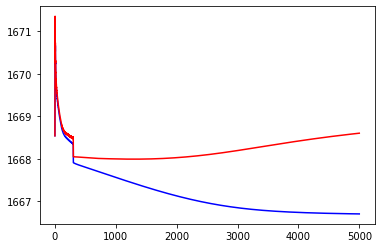

In [276]:
plt.plot(train_cost_value_list,'b') # train
plt.plot(test_cost_value_list,'r') # test

## 2. plot the accuracy curve

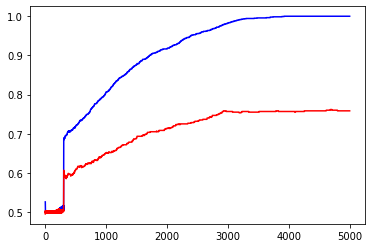

In [277]:
plt.plot(train_accuracy_list,'b')
plt.plot(test_accuracy_list,'r')

## 3. plot the quantitative results

- training results

In [278]:
# training results
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# confusion matrix 
print(confusion_matrix(y_train,train_predict_label))
# classification results
print(classification_report(y_train,train_predict_label))
# accuracy_score
print(accuracy_score(y_train, train_predict_label))

[[698   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

1.0


- testing results

In [279]:
# testing results
print(confusion_matrix(y_test,test_predict_label))
print(classification_report(y_test,test_predict_label))
print(accuracy_score(y_test, test_predict_label))

[[230  72]
 [ 73 225]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       302
           1       0.76      0.76      0.76       298

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

0.7583333333333333


## 4. testing accuracy

In [280]:
print(accuracy_score(y_test, test_predict_label)*100,'%')

75.83333333333333 %
